In [3]:
import pandas as pd
import numpy as np
import subprocess
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import random
import tqdm

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw, DataStructs
from rdkit import SimDivFilters

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn import metrics

# First collect the data we'll be working with and validation sets

In [3]:
# lets use the 37K+PK data as our training data
df = pd.read_csv('../data/data_prep_for_ml/data_prep_for_ml_pk_37k_screen/TRAIN_03_19_2022.csv')

# we'll hold out a random set from here for testing - 20% test set will be sufficient since it is random and class balanced
# so for testing, use '../data/TEST_03_19_2022.csv'

# we'll also test on all the validation molecules we have predicted on since their scaffolds are quite different- easy,med,hard,molport
# so for testing, use '../data/cleaned_easy_med_hard_val_sets_800k_10_03_2022.csv'
df

,Name,SMILES,hit
0,BRD-K93123848,Cn1c(nc2cc(ccc12)Oc1ccnc(c1)-c1ncc([nH]1)C(F)(...,1.0
1,BRD-K30309936,C[C@H]1CCCCO[C@H](CN(C)Cc2ccc(cc2)C(F)(F)F)[C@...,1.0
2,TRIMETHADIONE,CN1C(=O)OC(C)(C)C1=O,1.0
3,BRD-K76424103,C[C@]1([C@@H](N(Cc2ccccc2)C(=O)c2ccccc21)c1ccc...,1.0
4,BRD-K65130196,CC(C)(C)NCCCCOc1ccc(cc1C(C)(C)C)Cl,1.0
...,...,...,...
30962,BRD-K24978625,N[C@@H]1CC[C@@H](CCn2cc(nn2)C2CCCCC2)O[C@H]1CO,0.0
30963,BRD-K16976282,C[C@H]1CCCCO[C@H](CN(C)S(=O)(=O)C)[C@@H](C)CN(...,0.0
30964,BRD-K53638538,O[C@@H]1CCCC[C@H]1O,0.0
30965,BRD-K77119472,CO[C@@H]1CN(C)C(=O)c2cc(ccc2OC[C@H](C)N(C[C@@H...,0.0


# Let's split into sets where we have different proportions of positive:negative data

num pos:  1017.0
number of neg to test: [508, 1017, 2034, 4068, 8136, 16272, 29950]


100%|███████████████████████████████████| 29950/29950 [00:04<00:00, 6375.54it/s]


testing negative of #: 508


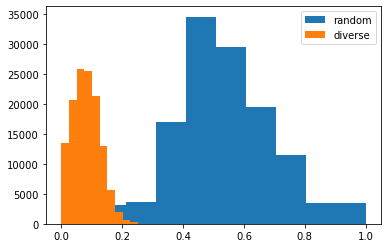

testing negative of #: 1017


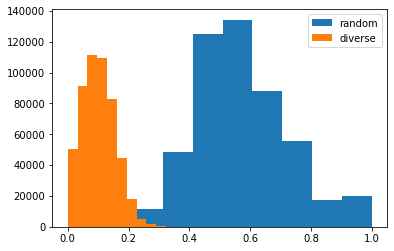

testing negative of #: 2034


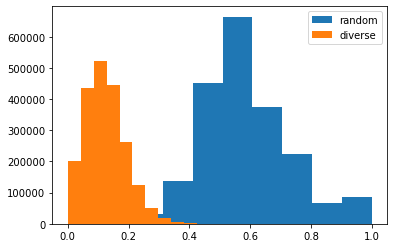

testing negative of #: 4068


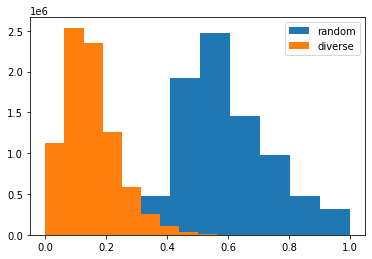

testing negative of #: 8136


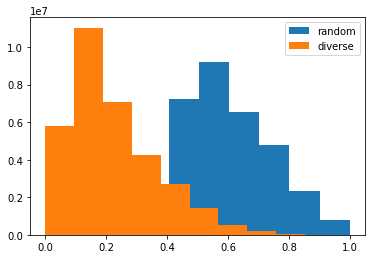

testing negative of #: 16272


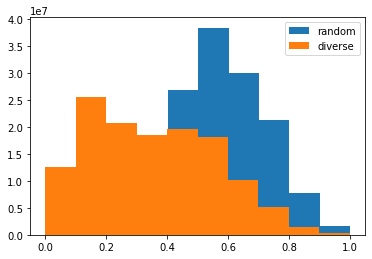

testing negative of #: 29950


In [6]:
pos = sum(df['hit'])
print('num pos: ', pos)

num_neg = [pos/2, pos, pos*2, pos*4, pos*8, pos*16, len(df)-pos]
num_neg = [int(x) for x in num_neg]
print('number of neg to test:', num_neg)

out_dir = '../out/experiment_to_test_different_negative_datasets/'

# preprocess some pos and neg dfs and fp lists for later processing
negative_options = df[df['hit'] == 0.0]
positive_options = df[df['hit'] == 1.0]

all_neg_fps = [Chem.RDKFingerprint(Chem.MolFromSmiles(smi)) for smi in list(negative_options['SMILES'])]
all_pos_fps = [Chem.RDKFingerprint(Chem.MolFromSmiles(smi)) for smi in list(positive_options['SMILES'])]

# preprocess sorted indices for second method of selection (most similar to positive)
tan_sims_from_all_neg_to_pos = [max(DataStructs.BulkTanimotoSimilarity(query_fp, all_pos_fps)) for query_fp in tqdm.tqdm(all_neg_fps)]
sorted_indices_most_similar = np.argsort([1.0 - x for x in tan_sims_from_all_neg_to_pos]) # subtract from 1 so we argsort in most similar to least similar


for i in num_neg:
    print('testing negative of #: ' + str(i))
    
    # build negative sets in different ways
    #### First way: random!
    rand_neg = negative_options.sample(n = i, replace = False)
    rand = pd.concat([rand_neg, positive_options]).sample(frac = 1) # add to pos and shuffle
    rand.to_csv(out_dir + 'random_N=' + str(i) + '.csv', index = False)

    if i == len(df) - pos:
        break # no need to compute multiple sets for the largest
        
    #### Second way: most similar to positive
    set_of_sorted_similar_indices = sorted_indices_most_similar[0:i]
    similar_neg = negative_options.iloc[set_of_sorted_similar_indices,:]
    similar = pd.concat([similar_neg, positive_options]).sample(frac = 1) # add to pos and shuffle
    similar.to_csv(out_dir + 'similar_N=' + str(i) + '.csv', index = False)
    
    # for proof that it's kinda random: 
    dist_hist=[]
    for i in range(len(set_of_sorted_similar_indices)):
        for j in range(i+1,len(set_of_sorted_similar_indices)):
            dist_hist.append(DataStructs.TanimotoSimilarity(all_neg_fps[set_of_sorted_similar_indices[i]],all_neg_fps[set_of_sorted_similar_indices[j]]))
    plt.hist(dist_hist, label = 'random')
    
    #### Third way: most diverse - use  MaxMin algorithm (Ashton, M. et. al., Quant. Struct.-Act. Relat., 21 (2002), 598-604).
    #### http://rdkit.blogspot.com/2014/08/picking-diverse-compounds-from-large.html
    #### takes a ton of time for larger Ns
    mmp = SimDivFilters.MaxMinPicker()
    diverse_indices = mmp.LazyBitVectorPick(all_neg_fps,len(all_neg_fps),i)
    diverse_neg = negative_options.iloc[diverse_indices,:]
    diverse = pd.concat([diverse_neg, positive_options]).sample(frac = 1) # add to pos and shuffle
    diverse.to_csv(out_dir + 'diverse_N=' + str(i) + '.csv', index = False)
    
    # for proof that it's diverse: 
    dist_hist=[]
    for i in range(len(diverse_indices)):
        for j in range(i+1,len(diverse_indices)):
            dist_hist.append(DataStructs.TanimotoSimilarity(all_neg_fps[diverse_indices[i]],all_neg_fps[diverse_indices[j]]))
    plt.hist(dist_hist, label = 'diverse')
    plt.legend()
    plt.show()
    

# Prep script to train models on these different datasets

In [7]:
bash_dir = 'experiment_to_test_diff_neg_datasets_train_models.sh'
for i in num_neg:
    for j in ['random', 'similar', 'diverse']:
        if i == len(df) - pos and j != 'random':
            continue
        clean_name = j + '_N=' + str(i)
        fold = 'models/experiment_with_diff_neg_datasets/'  + clean_name + '/'
        mk_folder_command = 'mkdir ' + fold
        train_command = 'chemprop_train --dropout 0.1 --hidden_size 500 --ffn_num_layers 2 --depth 3 --metric prc-auc --extra_metrics auc --save_dir ' + fold + ' --data_path out/experiment_to_test_different_negative_datasets/' + clean_name + '.csv --dataset_type classification --features_generator rdkit_2d_normalized --no_features_scaling --num_folds 5 --ensemble_size 2 --split_type scaffold_balanced --split_sizes 0.8 0.1 0.1 --smiles_columns SMILES --target_columns hit --gpu 0'
        
        file1 = open(bash_dir,"a") 
        file1.write(mk_folder_command + '; ' + train_command)
        file1.write('\n')
        file1.close()

# Use different neg dataset models to predict on 20% random test set + external val set

In [19]:
activate_command = 'conda activate chemprop; '
out_path = '../melis_gonorrhea/out/experiment_to_test_different_negative_datasets/'
num_neg = [508, 1017, 2034, 4068, 8136, 16272, 29950]
for i in num_neg:
    for j in ['random', 'similar', 'diverse']:
        for data_name, data in zip(['external_val', '20%_random_test'], ['cleaned_easy_med_hard_val_sets_800k_10_03_2022.csv', 'TEST_03_19_2022.csv']):
            clean_name = j + '_N=' + str(i)
            try:
                testdf = pd.read_csv('../out/experiment_to_test_different_negative_datasets/pred_' + data_name + '_' + clean_name + '.csv')
                continue # already exists
            except:
                print(clean_name, data)
                run_command = 'python predict.py --test_path ' + out_path + data + ' --checkpoint_dir ../melis_gonorrhea/models/controls_with_diff_neg_datasets/' + clean_name + '/ --preds_path ' + out_path + 'pred_' + data_name + '_' + clean_name + '.csv --features_generator rdkit_2d_normalized --no_features_scaling --smiles_column SMILES --ensemble_variance --gpu 0'
                full_command = activate_command + run_command
                test = subprocess.run(full_command, cwd="../../chemprop/", shell=True, capture_output=True)

similar_N=508 TEST_03_19_2022.csv
diverse_N=508 cleaned_easy_med_hard_val_sets_800k_10_03_2022.csv
diverse_N=508 TEST_03_19_2022.csv
random_N=1017 cleaned_easy_med_hard_val_sets_800k_10_03_2022.csv
random_N=1017 TEST_03_19_2022.csv
similar_N=1017 cleaned_easy_med_hard_val_sets_800k_10_03_2022.csv
similar_N=1017 TEST_03_19_2022.csv
diverse_N=1017 cleaned_easy_med_hard_val_sets_800k_10_03_2022.csv
diverse_N=1017 TEST_03_19_2022.csv
random_N=2034 cleaned_easy_med_hard_val_sets_800k_10_03_2022.csv
random_N=2034 TEST_03_19_2022.csv
similar_N=2034 cleaned_easy_med_hard_val_sets_800k_10_03_2022.csv
similar_N=2034 TEST_03_19_2022.csv
diverse_N=2034 cleaned_easy_med_hard_val_sets_800k_10_03_2022.csv
diverse_N=2034 TEST_03_19_2022.csv
random_N=4068 cleaned_easy_med_hard_val_sets_800k_10_03_2022.csv
random_N=4068 TEST_03_19_2022.csv
similar_N=4068 cleaned_easy_med_hard_val_sets_800k_10_03_2022.csv
similar_N=4068 TEST_03_19_2022.csv
diverse_N=4068 cleaned_easy_med_hard_val_sets_800k_10_03_2022.csv

# Quantify predictions

In [4]:
def modeleval(y_true, y_pred, name = ''):
    
    # Compute auROC 
    auroc = float(roc_auc_score(y_true, y_pred))
    
    # Compute Precision-Recall
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
    pr = float(auc(recall,precision))

    return(auroc, pr)

In [10]:
data_dir = '../out/experiment_to_test_different_negative_datasets/'
columns = ['N', 'Data Selection', 'Test Set', 'Metric', 'Value']
results = pd.DataFrame(columns = columns)
num_neg = [508, 1017, 2034, 4068, 8136, 16272, 29950]

for i in num_neg:
    for j in ['random', 'similar', 'diverse']:
        for data_name, data in zip(['external_val', '20%_random_test'], ['cleaned_easy_med_hard_val_sets_800k_10_03_2022.csv', 'TEST_03_19_2022.csv']):
            clean_name = j + '_N=' + str(i)
            
            true = pd.read_csv(data_dir + data)
            true = list(true['hit'])

            try:
                test = pd.read_csv(data_dir + 'pred_' + data_name + '_' + clean_name + '.csv')
            except:
                continue
            test = list(test['hit'])

            roc, pr = modeleval(true, test)
            row1 = [i, j, data_name, 'auROC', roc]
            row2 = [i, j, data_name, 'auPR', pr]
            new = pd.DataFrame([row1,row2], columns = columns)
            results = pd.concat([results, new])

In [12]:
# rename for plotting
results['Test Set'] = ['Restricted Similarity' if x=='external_val' else 'Random (20%)' for x in list(results['Test Set'])]
results

,N,Data Selection,Test Set,Metric,Value
0,508,random,Restricted Similarity,auROC,0.5
1,508,random,Restricted Similarity,auPR,0.531309
0,508,random,Random (20%),auROC,0.889213
1,508,random,Random (20%),auPR,0.243191
0,508,similar,Restricted Similarity,auROC,0.500909
...,...,...,...,...,...
1,16272,diverse,Random (20%),auPR,0.509586
0,29950,random,Restricted Similarity,auROC,0.705455
1,29950,random,Restricted Similarity,auPR,0.717247
0,29950,random,Random (20%),auROC,0.915193


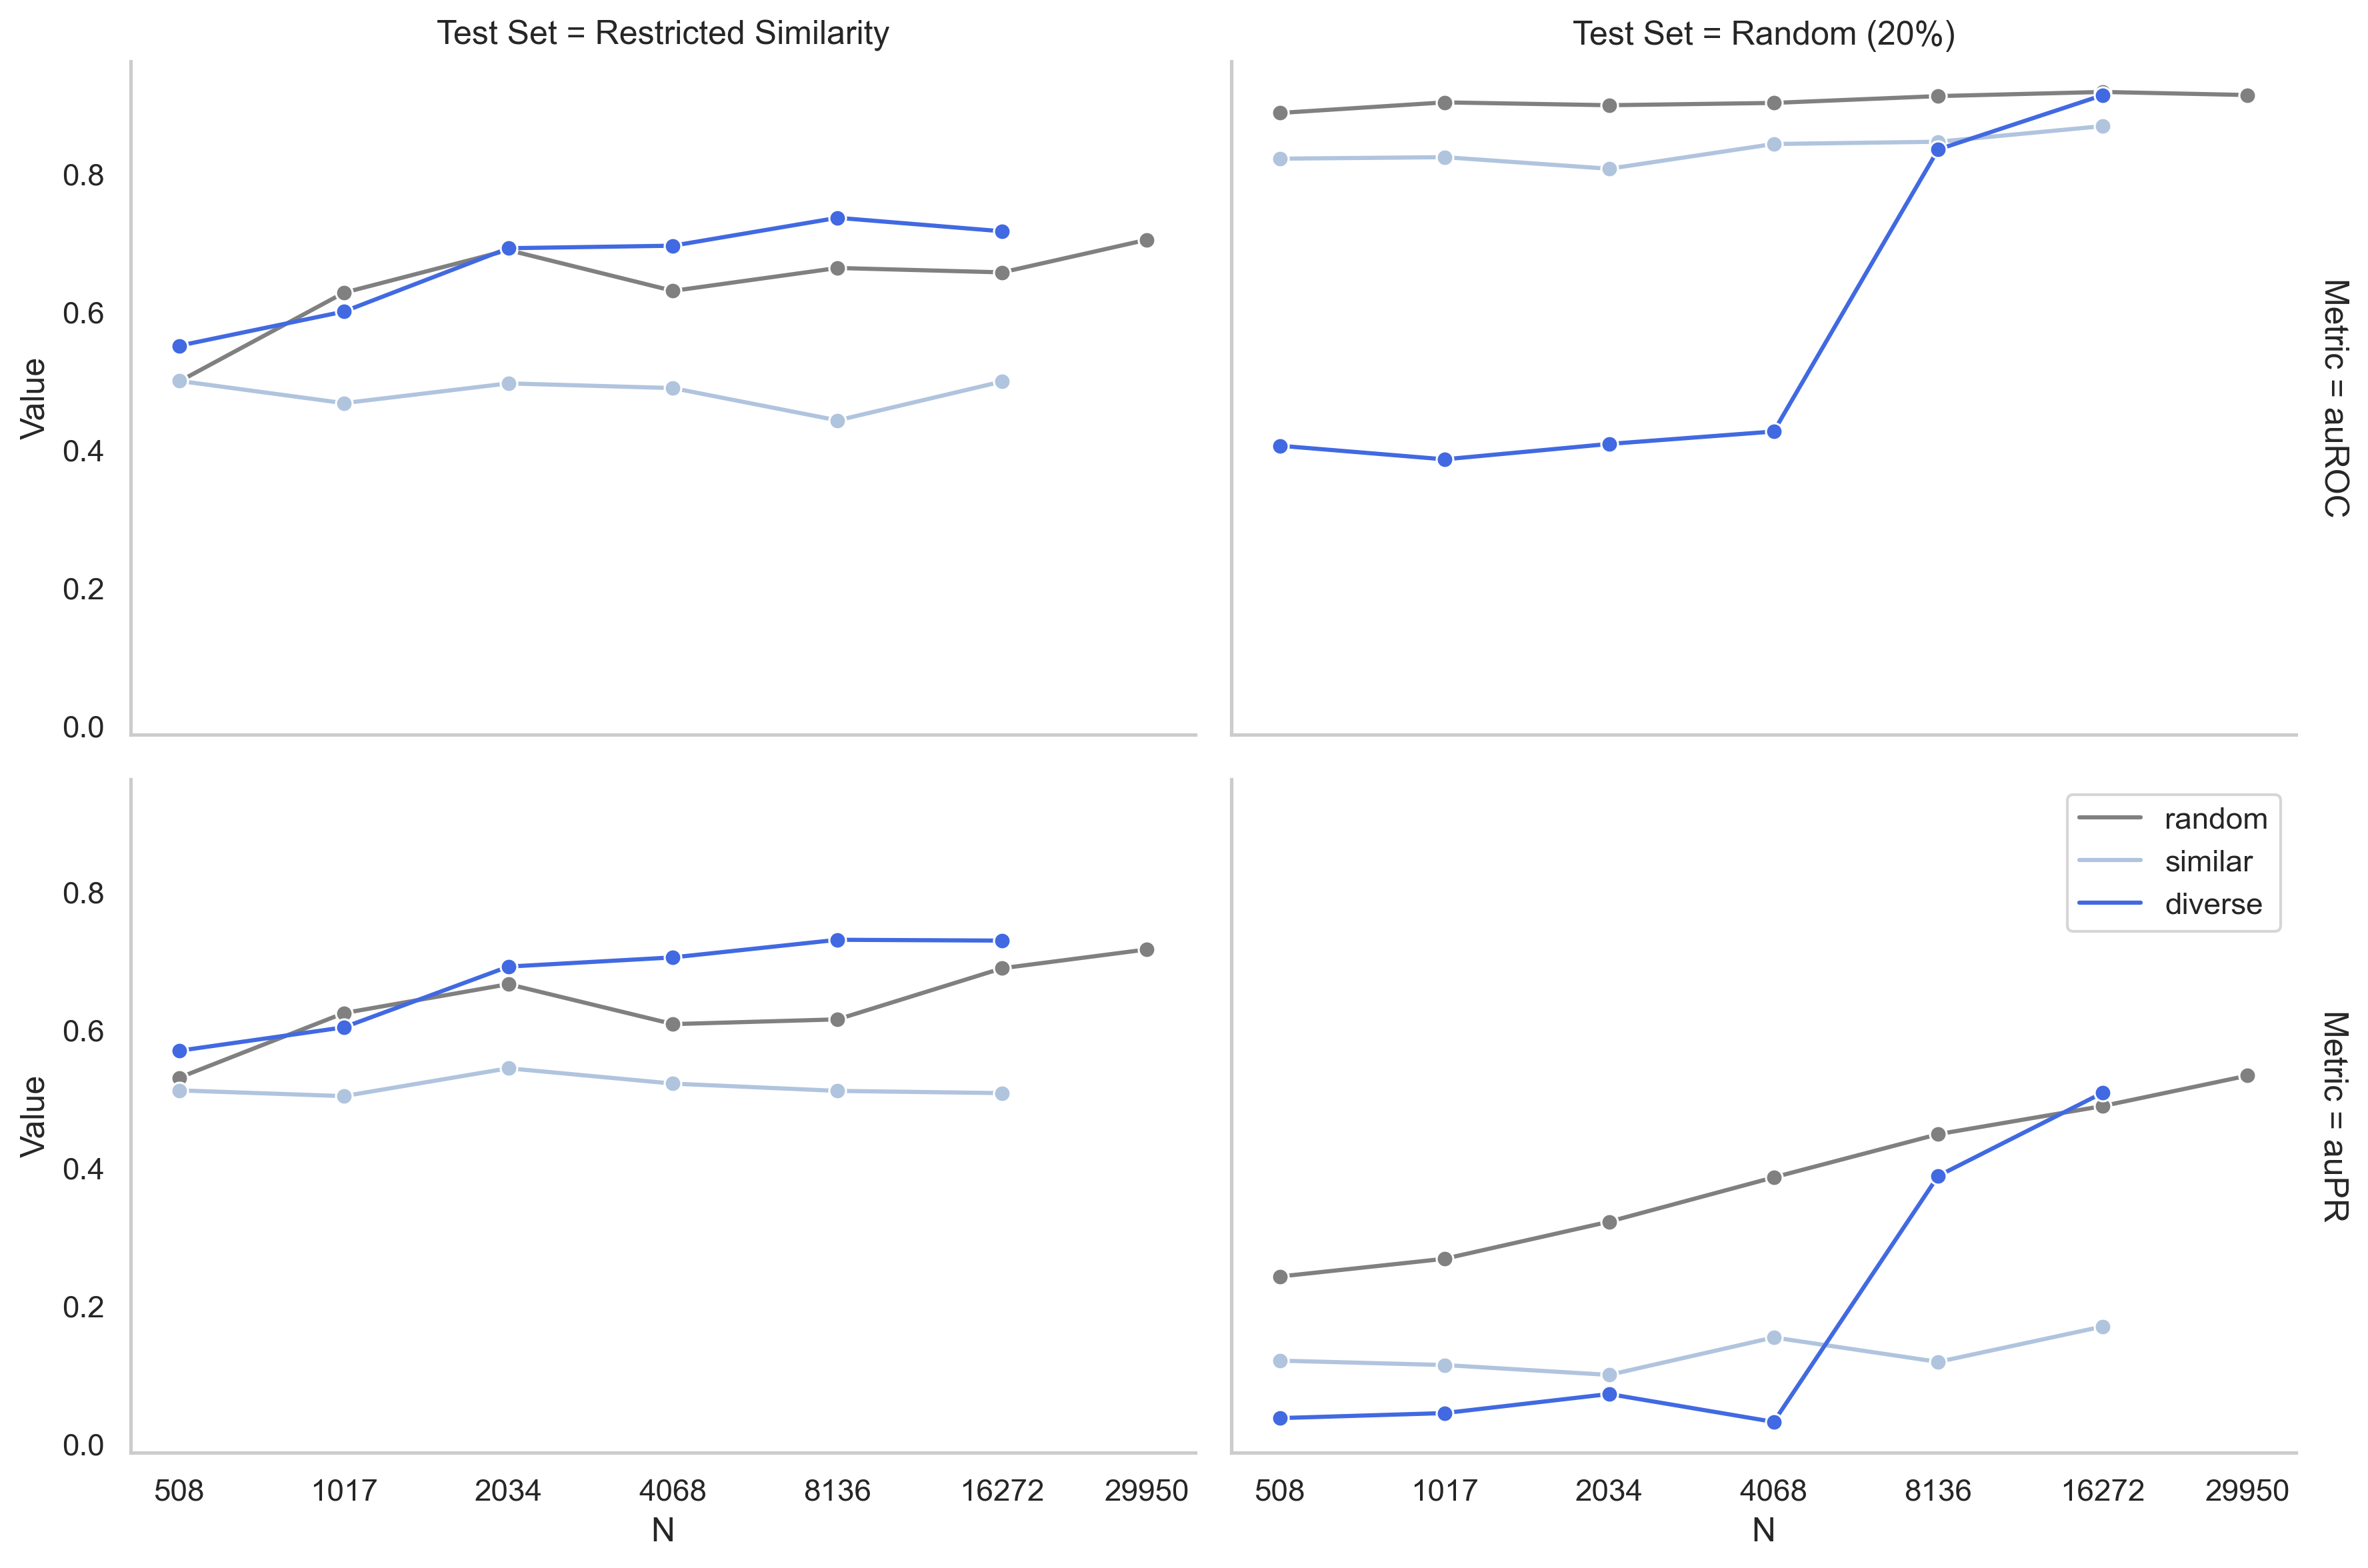

In [13]:
fig_path = '../figure_panels/negative_dataset_example'
results = results.reset_index(drop = True)
order = ['random', 'similar', 'diverse']
palette = dict(zip(order, ['grey', 'lightsteelblue', 'royalblue']))
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})
sns.set_style("whitegrid", {'axes.grid' : False})
g = sns.FacetGrid(results, row = 'Metric', col = 'Test Set', sharey = True, height=4, aspect=1.5, margin_titles=True)
g.map(sns.lineplot, 'N', 'Value', 'Data Selection', marker = 'o', dashes=True, hue_order = order, palette = palette)

for ax in g.axes_dict.values():
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
g.set(xscale='log')
g.set(xticks=num_neg)
g.set(xticklabels=num_neg)
plt.legend()
plt.tight_layout()
plt.savefig(fig_path + '.png')
plt.savefig(fig_path + '.svg')  
plt.show()